<br>

# <center> Sudoku Solving using Computer Vision

<br>

## <center> Part 02 : Image Processing

<br>

---

<br>


<br>

## Colab Configuration

### Mount Google Drive

In [1]:
'''
    This is required if the code runs in Google Colab.
    - this code will mount Google Drive for Colab.
    - the code needs to run only once.
'''

# # uncomment the below code, run and then comment again.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<br>

### Defining Root Directory

In [2]:
# this directory will be used as Root Directory to read/write any file
rootDir = '/content/drive/MyDrive/_ML/Sudoku/'

<br>

## Import Libraries

In [3]:
# importing all the required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os, random
import cv2

In [4]:
import json

<br>

## Loading Pretrained CNN Model

In [5]:
# defining the name of the model
modelName = 'DigitClassifier.h5'

# creating the path
path = rootDir + '03. Trainned Model/' + modelName

# loading saved models
from keras.models import load_model
model = load_model( path )

<br>

## Reading the Sudoku Puzzle

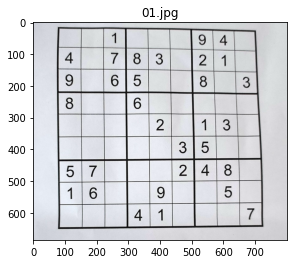

In [6]:
# defining the folder path of the sudoku puzzle images
folder = rootDir + "/02. DataSet/Sudoku/Images"

# randomly select an image from the folder
imgName = random.choice( os.listdir(folder) )

# defining image path
image_path = folder + '/' + imgName

# reading the Sudoku Puzzle
sudoku_raw = cv2.imread(image_path)

plt.title(imgName)
plt.imshow(sudoku_raw)
plt.show() 

<br>

## Preprocessing the Image

<br>

### Resizing the Image

In [7]:
# preprocessing image to be read
sudoku = cv2.resize(sudoku_raw, (450,450))

<br>

### Detecting the Contours of the Image

> Calculating Threshold Image

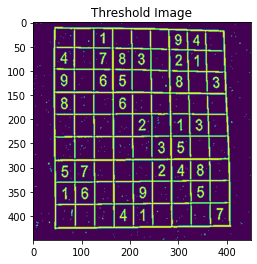

In [8]:
# function to greyscale, blur and change the receptive threshold of image
def get_threshold(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
    blur = cv2.GaussianBlur(gray, (3,3),6) 
    #blur = cv2.bilateralFilter(gray,9,75,75)
    threshold_img = cv2.adaptiveThreshold(blur,255,1,1,11,2)
    return threshold_img

threshold = get_threshold(sudoku)

# let's look at what we have got
plt.title('Threshold Image')
plt.imshow(threshold)
plt.show()

<br>

> Detect the biggest contour of the image.

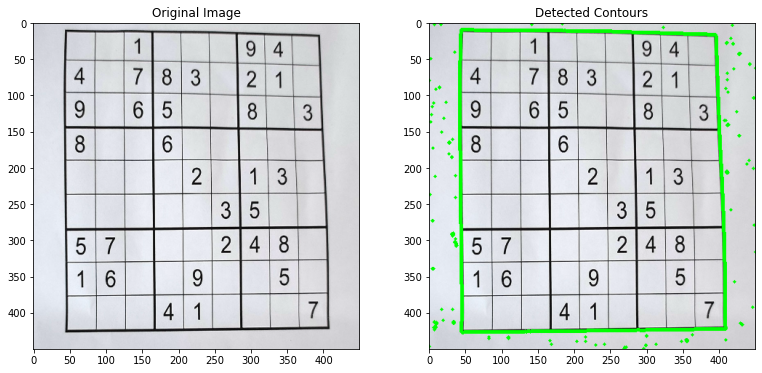

In [9]:
# Finding the outline of the sudoku puzzle in the image
contour, hierarchy = cv2.findContours(
                            threshold,
                            cv2.RETR_EXTERNAL,
                            cv2.CHAIN_APPROX_SIMPLE
                        )

contour_all = sudoku.copy()

cv2.drawContours(contour_all, contour, -1, (0,255,0), 3)


#let's see what we got
plt.figure(figsize=(13,6))

plt.subplot(1, 2, 1)
plt.imshow(sudoku)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(contour_all)
plt.title('Detected Contours')

plt.show()

<br>

### Reshaping the outline to get the cropped and well-aligned Sudoku

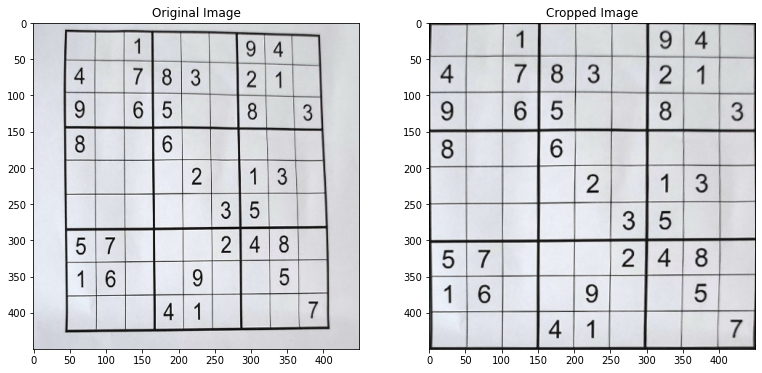

In [10]:
def main_outline(contour):
    biggest = np.array([])
    max_area = 0
    for i in contour:
        area = cv2.contourArea(i)
        if area >50:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i , 0.02* peri, True)
            if area > max_area and len(approx) ==4:
                biggest = approx
                max_area = area
    return biggest ,max_area

def reframe(points):
    points = points.reshape((4, 2))
    points_new = np.zeros((4,1,2),dtype = np.int32)
    add = points.sum(1)
    points_new[0] = points[np.argmin(add)]
    points_new[3] = points[np.argmax(add)]
    diff = np.diff(points, axis =1)
    points_new[1] = points[np.argmin(diff)]
    points_new[2] = points[np.argmax(diff)]
    return points_new


black_img = np.zeros((450,450,3), np.uint8)
sudoku_copy = sudoku.copy()

biggest, maxArea = main_outline(contour)

if biggest.size != 0:
    biggest = reframe(biggest)
    cv2.drawContours(sudoku_copy,biggest,-1, (0,255,0),10)
    pts1 = np.float32(biggest)
    pts2 = np.float32([[0,0],[450,0],[0,450],[450,450]])
    matrix = cv2.getPerspectiveTransform(pts1,pts2)  
    croppped_sudoku = cv2.warpPerspective(sudoku,matrix,(450,450))
    # imagewrap =cv2.cvtColor(imagewrap, cv2.COLOR_BGR2GRAY)
    

# displaying the images
plt.figure(figsize=(13,6))

plt.subplot(1, 2, 1)
plt.imshow(sudoku)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(croppped_sudoku)
plt.title('Cropped Image')

plt.show()

<br>

## Splitting the Cells

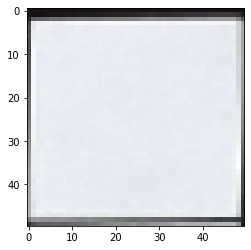

In [11]:
def splitcells(img):
    rows = np.vsplit(img,9)
    boxes = []
    for r in rows:
        cols = np.hsplit(r,9)
        for box in cols:
            boxes.append(box)
    return boxes


sudoku_cell = splitcells(croppped_sudoku)

#Let's have alook at the last cell
plt.figure()
plt.imshow(sudoku_cell[58])
plt.show()

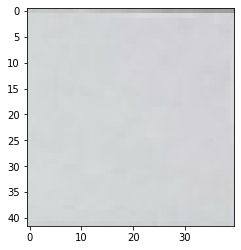

In [12]:
from PIL import Image 

# The sudoku_cell's output includes the boundaries this could lead to misclassifications by the model 
# I am cropping the cells to avoid that
# sneeking in a bit of PIL lib as cv2 was giving some weird error that i couldn't ward off

def CropCell(cells):
    Cells_croped = []
    for image in cells:
        
        img = np.array(image)
        img = img[4:46, 6:46]
        img = Image.fromarray(img)
        Cells_croped.append(img)
        
    return Cells_croped

sudoku_cell_croped = CropCell(sudoku_cell)

#Let's have alook at the last cell
plt.figure()
plt.imshow(sudoku_cell_croped[8])
plt.show()

<br>

## Classifying Digits

In [13]:
def read_cells(cells,model):

    result = []
    for cell in cells:
        img = np.asarray(cell)
        
        # preprocess the image as it was in the model 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = img[4:img.shape[0] - 4, 4:img.shape[1] -4]
        img = cv2.resize(img, (32, 32))
        img = img / 255
        img = img.reshape(1, 32, 32, 1)

        # getting predictions and setting the values if probabilities are above 65% 
        predictions = model.predict(img)
        probabilityValue = np.amax(predictions)
        classIndex = int( np.argmax(predictions, axis=1) )
        
        if probabilityValue > 0.65:
            result.append(classIndex)
        else:
            result.append(0)

    return result

grid = read_cells(sudoku_cell_croped, model)

1/1 [==============================] - 0s 29ms/step


<br>

## Reshaping the array into a 9 x 9 matrix

In [14]:
# converting to numpy array
puzzle = np.array(grid)

# Reshaping the grid to a 9x9 matrix
puzzle = np.reshape(puzzle, (9,9))

<br>

> Unsolved Sudoku

In [15]:
print('---------------------')
print(' Puzzle ')
print('--------------------- \n')

print(puzzle)

---------------------
 Puzzle 
--------------------- 

[[0 0 1 0 0 0 9 4 0]
 [4 0 7 8 3 0 2 1 0]
 [9 0 6 5 0 0 8 0 3]
 [8 0 0 6 0 0 0 0 0]
 [0 0 0 0 2 0 1 3 0]
 [0 0 0 0 0 3 5 0 0]
 [5 7 0 0 0 2 4 8 0]
 [1 6 0 0 9 0 0 5 0]
 [0 0 0 4 1 0 0 0 7]]


<br>
<br>

## Save the grid

In [16]:
fileName = 'data.json'
filePath = rootDir + '04. DataFrames/' + fileName

file_to_write = {
    'grid': grid,
    'image_path' : image_path
    }

# writing JSON file
with open(filePath,'w') as data: 
  data.write( json.dumps(file_to_write) )  # json.dumps() creates json in double quotes format